# PublicSource Residential Price Analysis

By Nora Mattson, Data Intern

This analysis was conducted to support visualizations for a PublicSource article about [community land trusts](https://www.publicsource.org/community-land-trusts-new-to-pittsburgh-shaped-by-pittsburgh/). Since the article relied upon assumptions about changes in the housing market, we thought that it would be relevant to show the audience what these changes were by visualizing the median housing prices in each of the neighborhoods setting up a community land trust. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

We used WPRDC's [Parcels n'at tool](http://tools.wprdc.org/parcels-n-at/#) because it makes it nice and easy to replicate with these or other neighborhoods. However, it is important to note that county assessment data doesn't always have the most updated real estate transactions, which is why we are only analyzing 2008-2018. Take a look at this [assessment data user guide](https://docs.google.com/document/d/1eYuJOh4_CBitclhhgeJv6iLStPjtouhXV1_2cwei_-s/edit) from WPRDC if you are interested in learning more about this data. 

In [12]:
neighborhoods = ["westoakland","bedforddwellings","centrallv","centraloakland","crawfordroberts","etna", 
                 "fineview","garfield","lowerlv","middlehill","millvale","northoakland","perryhilltop",
                 "polishhill","sharpsburg","southoakland","terracevillage","upperhill","upperlv"]
#data from WRPDC's parcels n'at tool, select the "house hunting" custom field list and add owner description

Then we put all of the different CSVs into a dataframe for analysis.

In [13]:
dfs = []
#add all of the neighborhoods to the dataframe
for nbhd in neighborhoods:
    df = pd.read_csv("median/%s.csv"%(nbhd))
    df["neighborhood__asmt"] = nbhd
    dfs.append(df)
meddf = pd.concat(dfs)
#rename columns
meddf.rename(columns=lambda x: x[:-6], inplace=True)

The Hill District is broken up into a bunch of smaller communities, as is Oakland and Lawrenceville, so we will go ahead and group them together. Additionally, let's look at the neighborhoods being grouped for community land trusts, Perry Hilltop and Fineview, as well as Etna, Millvale and Sharpsburg, together, which will both make more sense for this article and increase the sample size of the groups we are looking at. 

In [14]:
#rename all of the neighburhoods with multiple census tracts
meddf.loc[meddf["neighborhood"].isin(["westoakland", "centraloakland","northoakland","southoakland"]), "neighborhood"] = "oakland"
meddf.loc[meddf["neighborhood"].isin(["bedforddwellings", "crawfordroberts","upperhill","terracevillage","middlehill"]), "neighborhood"] = "hilldistrict"
meddf.loc[meddf["neighborhood"].isin(["upperlv", "centrallv","lowerlv"]), "neighborhood"] = "lawrenceville"
#for the sake of this analysis, we are grouping neighborhoods that are forming a CLT together
meddf.loc[meddf["neighborhood"].isin(["etna", "millvale","sharpsburg"]), "neighborhood"] = "riverboroughs"
meddf.loc[meddf["neighborhood"].isin(["perryhilltop", "fineview",]), "neighborhood"] = "perryhilltop/fineview"

meddf["neighborhood"].unique()

array(['oakland', 'hilldistrict', 'lawrenceville', 'riverboroughs',
       'perryhilltop/fineview', 'garfield', 'polishhill'], dtype=object)

### Cleaning

In [15]:
def residential(df):
    '''Filter so we are only looking at residential properties that have an actual structure on them.'''
    #Only looking at residential properties 
    df = df[df.CLASSDESC == "RESIDENTIAL"]
    #not looking at vacant properties
    df = df.loc[df.USEDESC !='VACANT LAND']
    return df

In the next step, we filter out sales that have been marked as invalid. We are interested in how much properties are actually being sold for, so prices that are lower because properties have been bundled, or because the seller is selling it to a family member for ten dollars, or higher because it involves a forced sale to the government, aren't that relevant for us. I decided to include sales that haven't been reviewed yet, so after that I went ahead and filtered out all sales less than $500 for a house, because those are likely invalid.

In [28]:
def validate(df):
    '''Filtering out sales that have been labeled as invalid representations of actual market price.'''
    #Making sure has been tagged as a valid sale
    df = df[df["SALECODE"].isin(['AA','0','U','UR'])]
    df = df[df.SALEPRICE >500]
    return df

The dataset includes the three most recent sales of each property, so I had to separate out the other two most recent sales so they can all be included in the analysis.

In [17]:
def separate(df):
    '''Seperating out each sale as a new row.'''
    #this dataset records the three most recent sales
    df["SALEYEAR"] = df.SALEDATE.str[-4:]
    df["PREVSALEYEAR"] = df.PREVSALEDATE.str[-4:]
    df["PREVSALEYEAR2"] = df.PREVSALEDATE2.str[-4:]
    #we only care about the prices
    price = df[["SALEYEAR","SALEPRICE","neighborhood"]]
    #add on the previous sale
    prev_price = df[['PREVSALEYEAR','PREVSALEPRICE',"neighborhood"]]
    prev_price.columns = ["SALEYEAR","SALEPRICE","neighborhood"]
    #add on the next previous sale
    prev_price2 = df[["PREVSALEYEAR2","PREVSALEPRICE2","neighborhood"]]
    prev_price2.columns = ["SALEYEAR","SALEPRICE","neighborhood"]
    allprice = price.append([prev_price.dropna(),prev_price2.dropna()], ignore_index = True,sort=True)
    allprice["SALEYEAR"] = pd.to_numeric(allprice["SALEYEAR"])
    return allprice

Finally, we filter the dataset so we are only looking at 2008-2018, because we only really interested in recent trends for this particular application. 

In [33]:
def clean(df):
    '''Cleaning the data and cutting it down to the years we are looking at.'''
    res = residential(df)
    val = validate(res)
    allprice = separate(val)
    #looking at years after housing crisis that have enough data 
    allprice = allprice[(allprice.SALEYEAR>2007)&(allprice.SALEYEAR<2019)]
    return allprice

In [19]:
medval = clean(meddf)
medval.head(5)

,SALEPRICE,SALEYEAR,neighborhood
0,112000.0,2012,oakland
4,85000.0,2016,oakland
6,110000.0,2010,oakland
9,81500.0,2008,oakland
11,86500.0,2010,oakland


In [31]:
medgroup = medval.groupby(["neighborhood","SALEYEAR"]).agg([np.median])["SALEPRICE"]
medgroup.unstack()

median                                          \
SALEYEAR                  2008      2009      2010      2011      2012   
neighborhood                                                             
garfield               55600.0    1473.0   10100.0   14250.0   33500.0   
hilldistrict           49900.0   70000.0   11601.0   23950.0   41950.0   
lawrenceville          45900.0   47500.0   64000.0   52756.0   56500.0   
oakland                89000.0  120000.0  110000.0  109000.0  100000.0   
perryhilltop/fineview  10000.0   22500.0    6500.0   11000.0   15000.0   
polishhill             42000.0   46000.0   69900.0   38000.0   82000.0   
riverboroughs          43000.0   60000.0   56250.0   58500.0   54450.0   

                                                                         \
SALEYEAR                   2013      2014      2015      2016      2017   
neighborhood                                                              
garfield                72500.0   47680.0   63500.0   65000.0   78250.0   
hilldistrict            57500.0   97500.0   81250.0   67000.0   60500.0   
lawrenceville           89500.0   69500.0  150000.0  165000.0  215000.0   
oakland                142500.0  118000.0  125000.0  159500.0  171650.0   
perryhilltop/fineview   30000.0   30000.0   48000.0   48500.0   67450.0   
polishhill              53500.0  107125.0  114000.0   90605.0  177500.0   
riverboroughs           61750.0   65000.0   64000.0   60000.0   59000.0   

                                 
SALEYEAR                   2018  
neighborhood                     
garfield               110000.0  
hilldistrict            55278.0  
lawrenceville          275000.0  
oakland                185407.0  
perryhilltop/fineview   43350.0  
polishhill             155500.0  
riverboroughs           61500.0

Take a look at the amount of data for each year. Note that some neighborhoods, like Polish Hill and Garfield have less data available, which might explain some of the fluctuations in their medians. 

In [32]:
medsize = medval.groupby(["neighborhood","SALEYEAR"]).agg([np.size])["SALEPRICE"]
medsize.unstack()

size                                                    \
SALEYEAR               2008  2009  2010   2011   2012  2013  2014  2015  2016   
neighborhood                                                                    
garfield               17.0  10.0  13.0   34.0   25.0  10.0  14.0  10.0  14.0   
hilldistrict           35.0  28.0  22.0   34.0   24.0  18.0   8.0  12.0  14.0   
lawrenceville          77.0  78.0  88.0  117.0  121.0  94.0  54.0  65.0  71.0   
oakland                75.0  83.0  79.0   87.0   71.0  78.0  39.0  37.0  40.0   
perryhilltop/fineview  43.0  24.0  27.0   50.0   35.0  17.0  25.0  20.0  20.0   
polishhill              9.0   9.0   9.0    8.0   11.0   4.0   4.0   7.0   6.0   
riverboroughs          86.0  68.0  74.0   62.0   84.0  56.0  33.0  39.0  47.0   

                                   
SALEYEAR               2017  2018  
neighborhood                       
garfield               18.0  19.0  
hilldistrict           28.0  21.0  
lawrenceville          67.0  67.0  
oakland                46.0  49.0  
perryhilltop/fineview  22.0  28.0  
polishhill              6.0   5.0  
riverboroughs          58.0  68.0

Let's do a quick visualization of the medians, we need to flip the order of "SALEYEAR", "neighborhood" in the groupby to actually plot it, because I just like how the other order displayed in the earlier table.

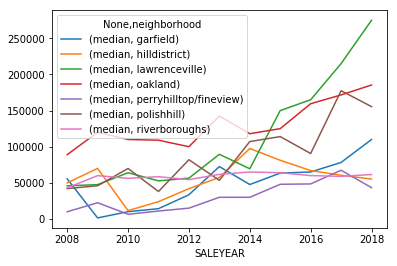

In [21]:
medval.groupby(["SALEYEAR","neighborhood"]).agg([np.median])["SALEPRICE"].unstack().plot()

Finally, here is the graphic in the article: 
![Median Prices](land_trust_graphics/median.png)